In [10]:
using Jacobi
using QuadGK
using GSL
using Plots
using PyPlot
using CSV
using DelimitedFiles
using ColorSchemes

In [11]:
"""
Physical parameters:
"""
ωc = 1; # Bath Spectral density cut-off frequency
ω0 = .25; # Sites coupling energy
α = 0.03; # Bath Spectral density coupling strength
s = 1; # Ohmic spectral density
beta = "inf"; # Bath inverse temperature

R = 5; # Sites separation
c_phonon = 1; # Phonon speed

N = 2; # number of sites

Nm = 100; # number of chainmodes

issoft=false; # is the cut-off of the spectral density a soft one or a hard one?

### Polybeta Function

In [12]:
function polybeta(t::Float64, n::Int, a::Array, b::Array, temp::Array)
    """
    polybeta recursively constructs the polynomials used to compute the coupling coefficients given the coefficients a and b
    this function is useful when working at finite temperature (beta != inf)
    """
          if n==-1
              return 0
          elseif n==0
              if length(temp)>=2
                  temp[2] = 1
              else
                  push!(temp,1)
              end
              
              return 1
          elseif n==1
              pn = (t - a[n])
              if length(temp) == 2
                  push!(temp,pn)
              elseif length(temp) == 1
                  push!(temp, 1)
                  push!(temp,pn)
              end
              
              return pn
          else
              if length(temp)<n+1 && temp[1] == t
                  pn = (t - a[n])*polybeta(t,n-1,a,b,temp) - b[n-1]*polybeta(t,n-2,a,b,temp) #P_{n}(t) = (t-a_{n-1})P_{n-1} - b_{n-1}P_{n-2}
                  push!(temp, pn)
                  
                  return pn
              elseif length(temp)<n+1 && temp[1] != t
                  temp = [t]
                  pn = (t - a[n])*polybeta(t,n-1,a,b,temp) - b[n-1]*polybeta(t,n-2,a,b,temp) #P_{n}(t) = (t-a_{n-1})P_{n-1} - b_{n-1}P_{n-2}
                  push!(temp, pn)
                  
                  return pn
              elseif length(temp) == n+1 && temp[1] == t
                   pn = (t - a[n])*temp[n+1] - b[n-1]*temp[n]
                   push!(temp,pn)
                   
                   return pn
               elseif length(temp) == n+1 && temp[1] != t
                   temp = [t]
                   pn = (t - a[n])*polybeta(t,n-1,a,b,temp) - b[n-1]*polybeta(t,n-2,a,b,temp) #P_{n}(t) = (t-a_{n-1})P_{n-1} - b_{n-1}P_{n-2}
                   push!(temp, pn)
                   
                   return pn
               elseif length(temp) > n+1 && temp[1] == t
                   pn = temp[n+2]
                   
                   return pn
               else
                   temp = [t]
                   pn = (t - a[n])*polybeta(t,n-1,a,b,temp) - b[n-1]*polybeta(t,n-2,a,b,temp) #P_{n}(t) = (t-a_{n-1})P_{n-1} - b_{n-1}P_{n-2}
                   push!(temp, pn)
                   
                   return pn
               end
          end
      end

polybeta (generic function with 1 method)

## Zero Temperature Polynomials ##

In [13]:
# Load the chain recurence coefficients
documentsdir = "./TDVPMPS/"
datfname = "chaincoeffs_ohmic_a$(α)wc$(ωc)xc$(ωc/c_phonon)beta$(beta).csv"
chaincoeffs = readdlm(string(documentsdir,datfname),',',Float64,'\n',skipstart=1)
a_chain = chaincoeffs[:,1];
b_chain = chaincoeffs[:,2].^2;

In [14]:
# Bath Ohmic Spectral Density for zero temperature chain mapping of the bath
    function SDOhmic(t)
        if t==0
            return 0
        elseif t>-1 && t<1
            return 2*α*abs(t)*ωc
        elseif abs(t)==1
            return 2*α*ωc
        else
            return 0
        end
    end

SDOhmic (generic function with 1 method)

In [15]:
# Compute the norms of the polynomials
Norm = []
for n=1:Nm
    polynomial(t) = polybeta(t,n-1,a_chain,b_chain,[t])
    N2(t) = polynomial(t)^2*SDTOhmic(t)
    push!(Norm,sqrt(quadgk(N2,-1,1)[1]))
end

UndefVarError: [91mUndefVarError: SDTOhmic not defined[39m

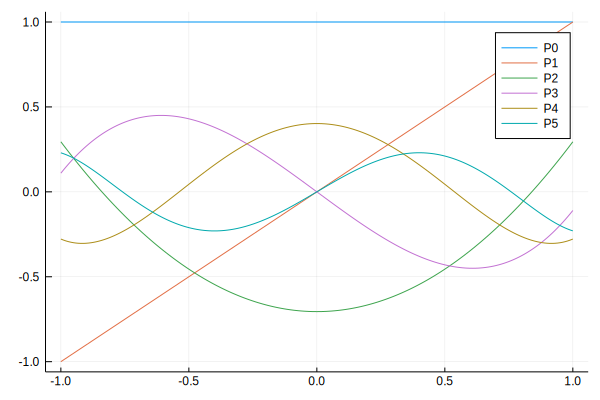

In [110]:
plt = plot(-1:0.01:1, t->polybeta(t,0,a_chain,b_chain, [1.]), label="P0")
for n=1:5
    plt = plot!(-1:0.01:1, t->polybeta(t,n,a_chain,b_chain, [1.]), label="P$(n)")
end
display(plt)

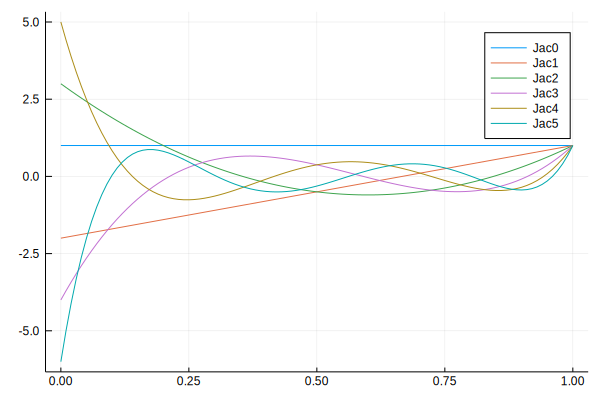

In [38]:
pltJac = Plots.plot(0:0.01:1, t->jacobi(2t-1,0,0,1), label="Jac0")
for n=1:5
    pltJac = Plots.plot!(0:0.01:1, t->jacobi(2*t-1,n,0,1), label="Jac$(n)")
end
display(pltJac)

## Coupling Coefficients ##

In [40]:
function γ(x::Int, n::Int, issoft::Bool; beta="inf", temp=[1.])
    polynomial(t) = jacobi(2*t-1,n-1, 0, s)*exp(-im*t*(x-1)*R*ωc/c_phonon)*t^s
	return sqrt(2*α*(2*(n-1) + s + 1))*ωc*quadgk(polynomial, 0, 1)[1]
end

γ (generic function with 1 method)

### Absolute Values ###

In [11]:
print(R)

10

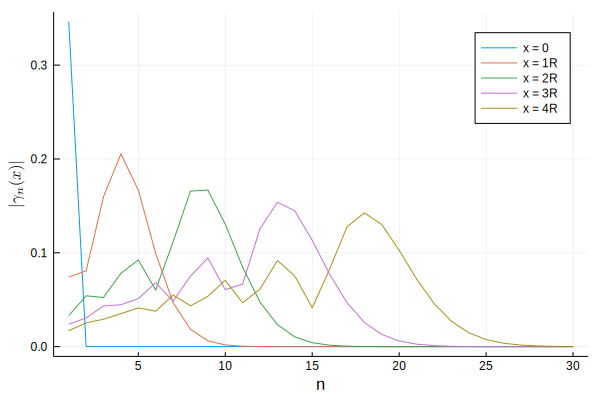

In [8]:
plotabs = Plots.plot(1:30, n->abs(γ(1,n,issoft)), label="x = 0")
for x=2:5
    plotabs = Plots.plot!(1:30, n->abs(γ(x,n,issoft)), label="x = $(x-1)R")
end
xlabel!("n")
ylabel!(L"|\gamma_n(x)|")
display(plotabs)

In [9]:
Plots.savefig("abs_coupling.pdf")

In [1]:
Plots.plot(1:30, n->abs(γ(Int64(1e2),n,issoft)), label="x = 327R")

UndefVarError: [91mUndefVarError: Plots not defined[39m

In [16]:
separation = [i for i=0:0.5:40];
modes = [n for n=1:30]

Z = zeros(length(separation), length(modes));

In [17]:
function γbis(x::Float64, n::Int, issoft::Bool; beta="inf", temp=[1.])
    polynomial(t) = jacobi(2*t-1,n-1, 0, s)*exp(-im*t*x*ωc/c_phonon)*t^s
	return sqrt(2*α*(2*(n-1) + s + 1))*ωc*quadgk(polynomial, 0, 1)[1]
end

γbis (generic function with 1 method)

In [18]:
for i=1:length(separation)
    for n=1:length(modes)
        Z[i,n] = abs(γbis(separation[i],modes[n],issoft))
    end
end

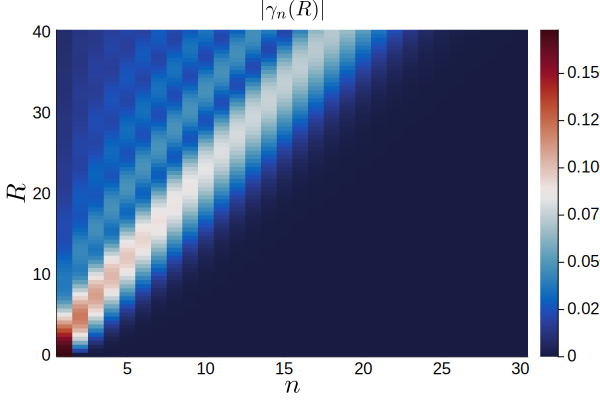

In [39]:
heatmap(modes,separation,Z, color=:balance, xguidefont=18, yguidefont=18, tickfontsize=11)
xlabel!(L"n")
ylabel!(L"R")
title!(L"|\gamma_n(R)|")

In [40]:
Plots.savefig("Abs_Couplings_heatmap_final.pdf")

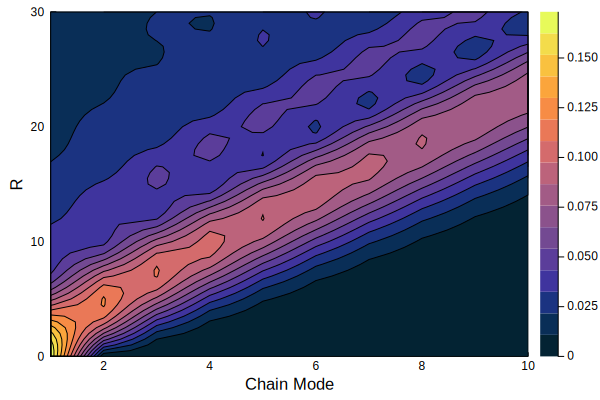

In [11]:
Plots.contour(modes, separation,Z, fill=true, color=:thermal)
xlabel!("Chain Mode")
ylabel!("R")

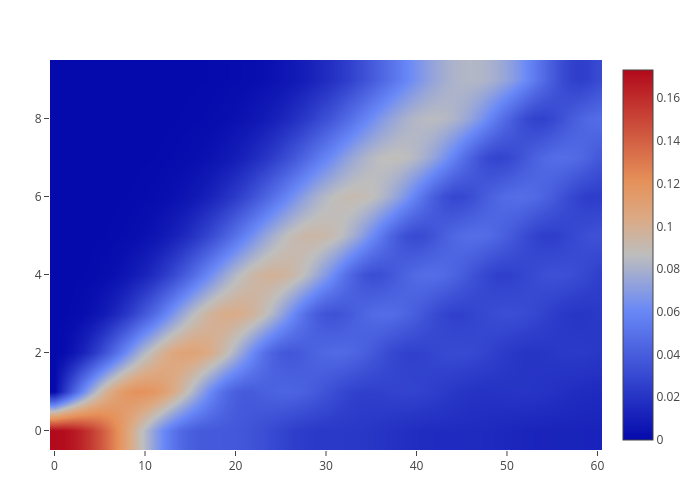

In [10]:
PlotlyJS.plot(PlotlyJS.heatmap(;z=Z, color=:thermal, zsmooth="best"))

In [9]:
using WebIO
using PlotlyJS

In [12]:
Plots.savefig("Abs_Couplings_heatmap_contour.pdf")

### Real and Imaginary Parts

In [41]:
function coupling(x,n)
    c = γ(x,n,issoft)
    return [real(c), imag(c)]
end

coupling (generic function with 1 method)

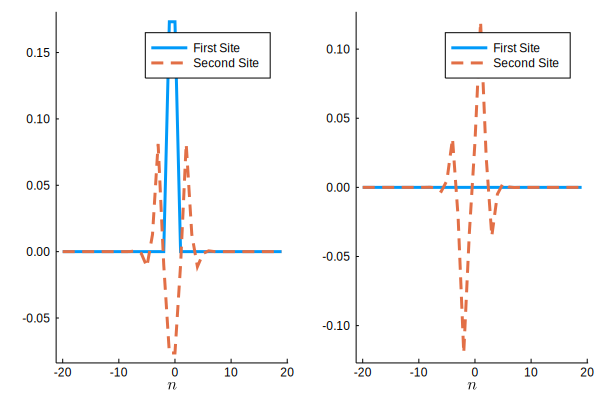

latex: failed to create a dvi file
latex: failed to create a dvi file
latex: failed to create a dvi file
latex: failed to create a dvi file
latex: failed to create a dvi file
latex: failed to create a dvi file
latex: failed to create a dvi file
latex: failed to create a dvi file


In [42]:
cRe = []
cIm = []
for n=1:20
    c = coupling(1,n)
    push!(cRe, c[1])
    push!(cIm, c[2])
end
plotcouplings = Plots.plot(-20:19, [vcat(cRe[end:-1:1],cRe), vcat(-cIm[end:-1:1],cIm)], linestyle=:auto, linewidth=3, label=["First Site" "First Site"], xlabel=[L"n" L"n"], ylabel=[L"\mathrm{Re}\[\gamma_n(R)\]" L"\mathrm{Im}\[\gamma_n(R)\]"],layout=(1,2), grid=:none)
for x=2:2
    cRe = []
    cIm = []
    for n=1:20
        c = coupling(x,n)
        push!(cRe, c[1])
        push!(cIm, c[2])
    end
    plotcouplings = Plots.plot!(-20:19, [vcat(cRe[end:-1:1],cRe), vcat(-cIm[end:-1:1],cIm)], linestyle=:auto, linewidth=3, label=["Second Site" "Second Site"], layout=(1,2), grid=:none)
end
display(plotcouplings)

In [109]:
Plots.savefig("couplings_re_im.pdf")

In [43]:
cRe1 = []
cIm1 = []
cRe2 = []
cIm2 = []
for n=1:20
    c1 = coupling(1,n)
    push!(cRe1, c1[1])
    push!(cIm1, c1[2])
    c2 = coupling(2,n)
    push!(cRe2, c2[1])
    push!(cIm2, c2[2])
end

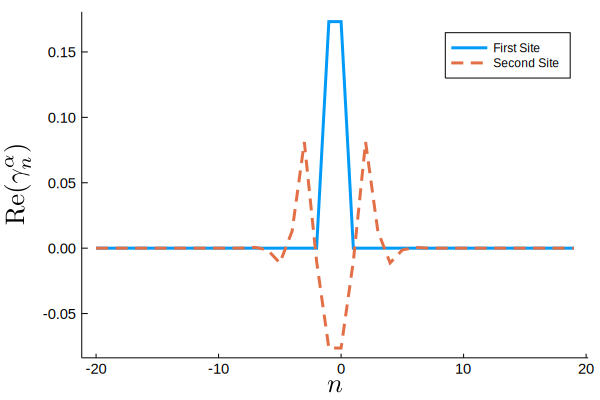

In [44]:
plotRe = Plots.plot(-20:19, [vcat(cRe1[end:-1:1],cRe1), vcat(cRe2[end:-1:1],cRe2)], linestyle=:auto, linewidth=3, label=["First Site" "Second Site"], xlabel=L"n", ylabel=L"\mathrm{Re}(\gamma_n^\alpha)", grid=:none,guidefontsize=18, tickfontsize=10, legend=:best)

In [118]:
Plots.savefig("couplings_re.pdf")

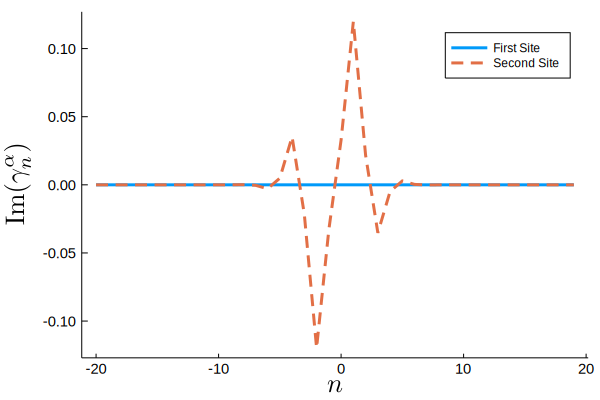

In [45]:
plotIm = Plots.plot(-20:19, [vcat(cIm1[end:-1:1],cIm1), vcat(-cIm2[end:-1:1],cIm2)], linestyle=:auto, linewidth=3, label=["First Site" "Second Site"], xlabel=L"n", ylabel=L"\mathrm{Im}(\gamma_n^\alpha)", grid=:none,guidefontsize=18, tickfontsize=10, legend=:best)

In [121]:
Plots.savefig("couplings_im.pdf")

### Miscellaneous

In [25]:
# Bath Ohmic Spectral Density after the finite temperature chain mapping of the bath
function SDTOhmic(t)
    if t==0
        return 2*α/β
   elseif t>-1 && t<1
        return α*t*ωc*(1+coth(β*t*ωc*0.5))
    elseif abs(t)==1
        return α*t*ωc*(1+coth(β*t*ωc*0.5))
    else
        return 0
    end
end

SDTOhmic (generic function with 1 method)

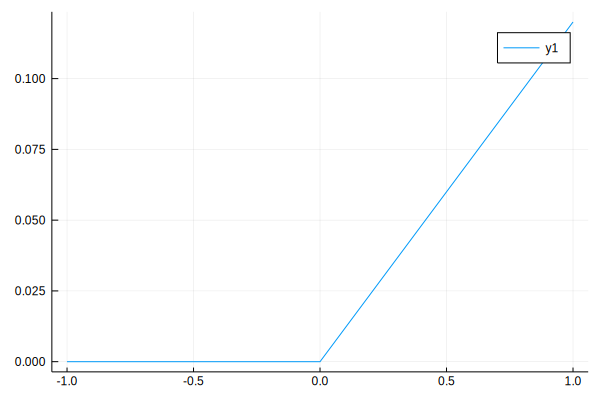

In [25]:
β = 100000;
Plots.plot(-1:0.01:1, t->SDTOhmic(t))

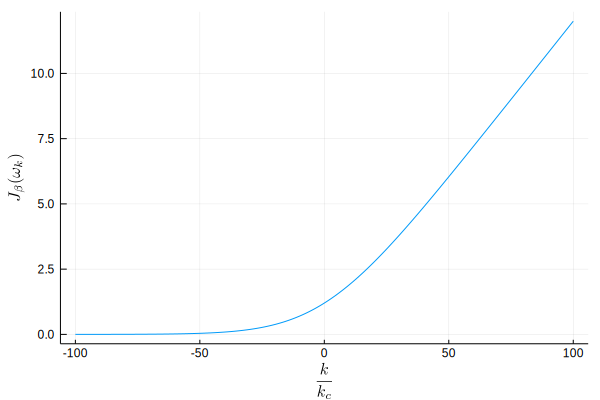

In [10]:
Jbeta(t) = t == 0 ? 4*α/β : 2*α*ωc*t*(1+coth(β*t*ωc*0.5))
Plots.plot(-100:100, t->Jbeta(t), label=:none)
xlabel!(L"\frac{k}{k_c}")
ylabel!(L"J_\beta(\omega_k)")

## Completely recursive calculation of polynomials

In [5]:
weight(t) = SDOhmic(t)
a = 0; b = 1;
eps_alpha = 1e-6;

In [6]:
PreviousPol = [t->0, t->1];
Norm2 = [0, quadgk(weight,a,b)[1]];
alpha_p = [];
beta_p = [];

In [50]:
function monic(n, PreviousPol, Norm2, weight)
    if length(PreviousPol) >= n
        return PreviousPol[n]
    elseif length(PreviousPol) == n-1
        numerator = quadgk(t->t*PreviousPol[n-1](t)^2*weight(t),a,b)[1]
        alpha = numerator/Norm2[n-1] <= eps_alpha ? 0 : numerator/Norm2[n-1] #If the numerator is too small, it's probably numerical errors
        beta = Norm2[n-2] == 0 ? 0 : Norm2[n-1]/Norm2[n-2] # If n corresponds to P_{-1} then beta=0
        pn = t->(t - alpha)*PreviousPol[n-1](t) - beta*PreviousPol[n-2](t)
        push!(PreviousPol, pn)
        push!(Norm2, quadgk(t->pn(t)^2*weight(t), a, b)[1])
        push!(alpha_p,alpha)
        push!(beta_p,beta)
        return pn
    elseif length(PreviousPol) <= n-2
        pnminus1(t) = (monic(n-1, PreviousPol,Norm2, weight))(t)
        numerator = quadgk(t->t*pnminus1(t)^2*weight(t),a,b)[1]
        alpha = numerator/Norm2[n-1] <= eps_alpha ? 0 : numerator/Norm2[n-1]
        beta = Norm2[n-1]/Norm2[n-2]
        pn = t->(t - alpha)*PreviousPol[n-1](t) - beta*PreviousPol[n-2](t)
        push!(PreviousPol, pn)
        push!(Norm2, quadgk(t->pn(t)^2*weight(t), a, b)[1])
        push!(alpha_p,alpha)
        push!(beta_p,beta)
        return pn
    end
end

monic (generic function with 1 method)

In [32]:
testmonic = monic(7,PreviousPol,Norm2, weight);

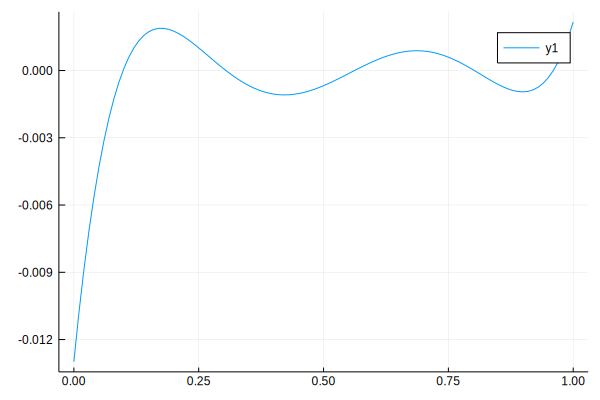

In [33]:
Plots.plot(a:0.01:b, t->testmonic(t))

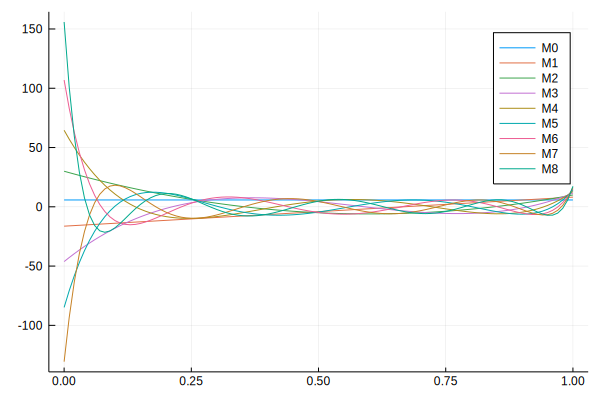

In [16]:
pltmonic = Plots.plot(a:0.01:b, t->(monic(2,PreviousPol,Norm2,weight))(t)/sqrt(Norm2[2]), label="M0")
for n=3:10
    pltmonic = Plots.plot!(a:0.01:b, t->(monic(n,PreviousPol,Norm2,weight))(t)/sqrt(Norm2[n]), label="M$(n-2)")
end
display(pltmonic)

In [18]:
beta_p

8-element Array{Any,1}:
 0                   
 0.05555555555555555 
 0.05999999999999999 
 0.06122448979591835 
 0.061728395061728385
 0.06198347107438015 
 0.06213017751479288 
 0.06222222222222228 

#### Difference between Jacobi and monic

In [91]:
NormJac = [sqrt(quadgk(t->(jacobi(t,n,0,1)^2*(1+t)),-1,1)[1]) for n=0:5]

6-element Array{Float64,1}:
 1.4142135623730951
 0.9999999999999999
 0.8164965809277259
 0.7071067811865474
 0.6324555320336757
 0.5773502691896255

In [100]:
for n=0:5
    temp = [abs(jacobi(2*t-1,n,0,1)/NormJac[n+1] - (monic(n+2,PreviousPol,Norm2,weight))(2*t-1)/sqrt(Norm2[n+2])) for t=0:0.01:1]
    print("n = $(n): $(max(temp...)) \n")
end

n = 0: 5.06639591070971 
n = 1: 38.824829046386306 
n = 2: 246.32576538582526 
n = 3: 1483.9068402597425 
n = 4: 8783.766501740418 
n = 5: 14945.887164836253 


#### Difference between polybeta and monic

In [109]:
for n=0:5
    temp = [abs(polybeta(t,n,a_chain,b_chain,[1.])/Norm[n+1] - (monic(n+2,PreviousPol,Norm2,weight))(t)/sqrt(Norm2[n+2])) for t=0:0.01:1]
    print("n = $(n): $(max(temp...)) \n")
end

n = 0: 1.691019787257627 
n = 1: 15.855355716743432 
n = 2: 37.76876689473925 
n = 3: 46.67883215174612 
n = 4: 59.9409043276458 
n = 5: 23.833961797401024 


#### Orthogonality

In [110]:
quadgk(t->polybeta(t,2,a_chain,b_chain,[1.])*SDOhmic(t),0,1)

(-0.0035645629732793394, 1.3010426069826053e-18)

In [111]:
quadgk(t->polybeta(t,4,a_chain,b_chain,[1.])*SDOhmic(t),0,1)

(-0.004516662580528811, 8.673617379884035e-19)

In [112]:
quadgk(t->monic(4,PreviousPol,Norm2,SDOhmic)(t)*SDOhmic(t),0,1)

(-1.6263032587282567e-19, 0.0)

In [113]:
quadgk(t->monic(6,PreviousPol,Norm2, SDOhmic)(t)*SDOhmic(t),0,1)

(5.759824041329242e-20, 0.0)

In [87]:
quadgk(t->monic(4,PreviousPol,Norm2,x->1+x)(t)*(t+1),-1,1)

(-2.47198095326695e-17, 0.0)

In [88]:
quadgk(t->monic(5,PreviousPol,Norm2,x->1+x)(t)*(t+1),-1,1)

(2.880219885688698e-16, 2.1013298140042806e-23)

In [117]:
quadgk(t->monicread(4,PreviousPol,Norm2, SDOhmic, a_chain, b_chain)(t)*SDOhmic(t),0,1)

(-0.013385860278054237, 1.734723475976807e-18)

# Finite Temperature

In [53]:
# Bath Ohmic Spectral Density after the finite temperature chain mapping of the bath
function SDTOhmic(t)
    if t==0
        return 2*α/β
    elseif t>-1 && t<1
        return α*t*ωc*(1+coth(β*t*ωc*0.5))
    elseif abs(t)==1
        return α*t*ωc*(1+coth(β*t*ωc*0.5))
    else
        return 0
    end
end

SDTOhmic (generic function with 2 methods)

In [10]:
R = 10; β=beta;

In [54]:
weight(t) = SDTOhmic(t)
a = -1; b = 1;
eps_alpha = 1e-6;
PreviousPolT = [t->0, t->1];
Norm2T = [0, quadgk(SDTOhmic,a,b)[1]];
alpha_p = [];
beta_p = [];

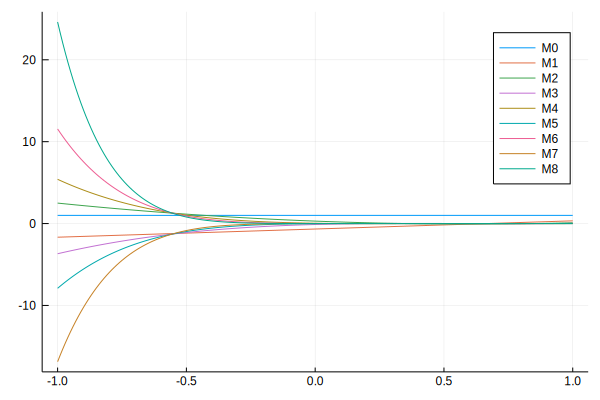

In [93]:
pltmonic = Plots.plot(-1:0.01:1, t->(monic(2,PreviousPolT,Norm2T, weight))(t), label="M0")
for n=3:10
    pltmonic = Plots.plot!(-1:0.01:1, t->(monic(n,PreviousPolT,Norm2T, weight))(t), label="M$(n-2)")
end
display(pltmonic)

In [94]:
beta_p

8-element Array{Any,1}:
 0                   
 0.05555555555555555 
 0.05999999999999999 
 0.06122448979591835 
 0.061728395061728385
 0.06198347107438015 
 0.06213017751479288 
 0.06222222222222228 

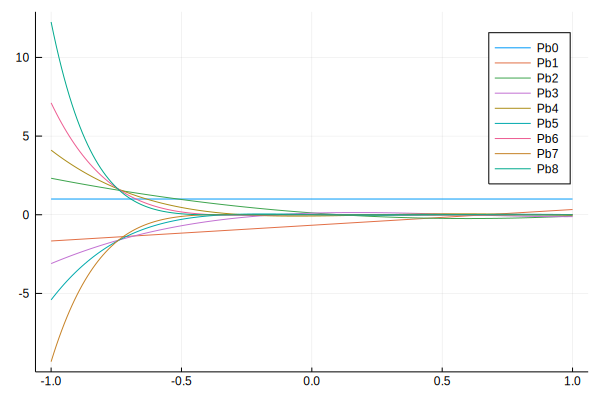

In [63]:
pltbeta = Plots.plot(-1:0.01:1, t->polybeta(t,0,a_chain,b_chain,[t]), label="Pb0")
for n=1:8
    pltbeta = Plots.plot!(-1:0.01:1, t->polybeta(t,n,a_chain,b_chain,[t]), label="Pb$(n)")
end
display(pltbeta)

In [65]:
for n=0:5
    temp = [abs( (monic(n+2,PreviousPolT,Norm2T,SDTOhmic))(t)/sqrt(Norm2T[n+2]) - polybeta(t,n,a_chain,b_chain,[t])/Norm[n+1]) for t=-1:0.01:1]
    print("n = $(n): $(max(temp...)) \n")
end

n = 0: 0.0 
n = 1: 21.86611303901606 
n = 2: 168.08591680288882 
n = 3: 1042.9821513138818 
n = 4: 6204.965811414695 
n = 5: 36517.08547127179 


#### Orthogonality

In [91]:
quadgk(t->polybeta(t,2,a_chain,b_chain,[1.])*SDTOhmic(t),-1,1)

(-0.010808802319456488, 1.734723475976807e-18)

In [67]:
quadgk(t->polybeta(t,4,a_chain,b_chain,[1.])*SDTOhmic(t),-1,1)

(0.0011960619826581662, 0.0)

In [68]:
quadgk(t->monic(4,PreviousPolT,Norm2T, SDTOhmic)(t)*SDTOhmic(t),-1,1)

(-3.2526065174565133e-19, 0.0)

In [69]:
quadgk(t->monic(6,PreviousPolT,Norm2T, SDTOhmic)(t)*SDTOhmic(t),-1,1)

(1.1519648082658485e-19, 0.0)

In [102]:
quadgk(t->monicread(4,PreviousPolT,Norm2T, SDTOhmic, a_chain, b_chain)(t)*SDTOhmic(t),-1,1)

(-1.1843538736538983e-11, 0.0)

In [103]:
quadgk(t->monicread(6,PreviousPolT,Norm2T, SDTOhmic, a_chain, b_chain)(t)*SDTOhmic(t),-1,1)

(-1.5666027841838327e-12, 2.202285662861181e-20)

In [17]:
# Compute the norms of the polynomials
Norm = []
for n=1:20
    polynomial(t) = polybeta(t,n-1,a_chain,b_chain,[t]) #(monic(n+1,PreviousPolT,Norm2T, weight=weight))(t)
    N2(t) = polynomial(t)^2*SDTOhmic(t)
    push!(Norm,sqrt(quadgk(N2,-1,1)[1]))
end

In [64]:
Norm2T

2-element Array{Float64,1}:
 0.0                
 0.48332503525949067

In [56]:
function γT(x::Int, n::Int, issoft::Bool; beta=0.5, temp=[1.])
    polynomialb(t) = polybeta(t,n-1,a_chain,b_chain,[t]) #(monic(n+1,PreviousPolT,Norm2T,weight))(t) 
    integrand(t) = polynomialb(t)*exp(-im*t*(x-1)*R*ωc/c_phonon)*SDTOhmic(t,beta)
    r = quadgk(integrand, -1, 1)[1]
    return (ωc/sqrt(Norm2T[n]))*r
end

γT (generic function with 1 method)

In [16]:
Nm = 25;

In [17]:
plotabs = Plots.plot(1:Nm, n->abs(γT(1,n,issoft)), label="x = 0")
for x=2:5
    plotabs = Plots.plot!(1:Nm, n->abs(γT(x,n,issoft)), label="x = $(x-1)R")
end
xlabel!("n")
ylabel!(L"|\gamma_n(x)|")
display(plotabs)

InterruptException: [91mInterruptException:[39m

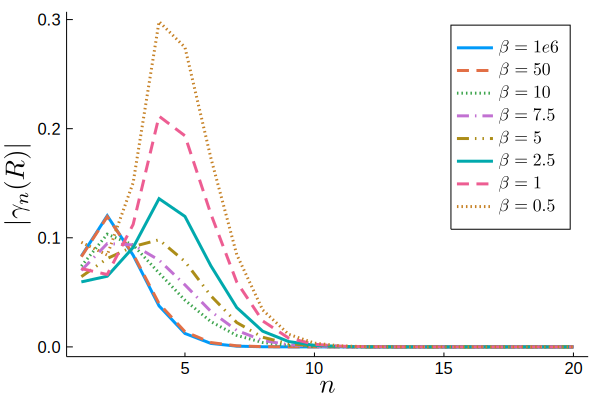

In [57]:
R=5; Nm=20;

β=beta=1e6;

# Load the chain recurence coefficients
documentsdir = "./TDVPMPS/"
datfname = "chaincoeffs_ohmic_a$(α)wc$(ωc)xc$(ωc/c_phonon)beta$(beta).csv"
chaincoeffs = readdlm(string(documentsdir,datfname),',',Float64,'\n',skipstart=1)
a_chain = chaincoeffs[:,1];
b_chain = chaincoeffs[:,2].^2;
PreviousPol = [t->0, t->1];
Norm2 = [0, quadgk(weight,a,b)[1]];
# Compute the norms of the polynomials
Norm2T = []
for n=1:Nm
    polynomial(t) = polybeta(t,n-1,a_chain,b_chain,[t])
    N2(t) = polynomial(t)^2*SDTOhmic(t)
    push!(Norm2T,(quadgk(N2,-1,1)[1]))
end
plotabs = Plots.plot(1:Nm, n->abs(γT(2,n,issoft,beta=beta)), label=L"\beta = 1e6", legendfont=font(12), grid=:none,linestyle=:auto,linewidth=3)

β=beta=50;

# Load the chain recurence coefficients
documentsdir = "./TDVPMPS/"
datfname = "chaincoeffs_ohmic_a$(α)wc$(ωc)xc$(ωc/c_phonon)beta$(beta).csv"
chaincoeffs = readdlm(string(documentsdir,datfname),',',Float64,'\n',skipstart=1)
a_chain = chaincoeffs[:,1];
b_chain = chaincoeffs[:,2].^2;
PreviousPol = [t->0, t->1];
Norm2 = [0, quadgk(weight,a,b)[1]];
Norm2T = []
for n=1:Nm
    polynomial(t) = polybeta(t,n-1,a_chain,b_chain,[t])
    N2(t) = polynomial(t)^2*SDTOhmic(t)
    push!(Norm2T,(quadgk(N2,-1,1)[1]))
end
plotabs = Plots.plot!(1:Nm, n->abs(γT(2,n,issoft,beta=beta)), label=L"\beta = 50",linestyle=:auto,linewidth=3)

β=beta=10;

# Load the chain recurence coefficients
documentsdir = "./TDVPMPS/"
datfname = "chaincoeffs_ohmic_a$(α)wc$(ωc)xc$(ωc/c_phonon)beta$(beta).csv"
chaincoeffs = readdlm(string(documentsdir,datfname),',',Float64,'\n',skipstart=1)
a_chain = chaincoeffs[:,1];
b_chain = chaincoeffs[:,2].^2;
PreviousPol = [t->0, t->1];
Norm2 = [0, quadgk(weight,a,b)[1]];
Norm2T = []
for n=1:Nm
    polynomial(t) = polybeta(t,n-1,a_chain,b_chain,[t])
    N2(t) = polynomial(t)^2*SDTOhmic(t)
    push!(Norm2T,(quadgk(N2,-1,1)[1]))
end
plotabs = Plots.plot!(1:Nm, n->abs(γT(2,n,issoft,beta=beta)), label=L"\beta = 10",linestyle=:auto,linewidth=3)

β=beta=7.5;

# Load the chain recurence coefficients
documentsdir = "./TDVPMPS/"
datfname = "chaincoeffs_ohmic_a$(α)wc$(ωc)xc$(ωc/c_phonon)beta$(beta).csv"
chaincoeffs = readdlm(string(documentsdir,datfname),',',Float64,'\n',skipstart=1)
a_chain = chaincoeffs[:,1];
b_chain = chaincoeffs[:,2].^2;
PreviousPol = [t->0, t->1];
Norm2 = [0, quadgk(weight,a,b)[1]];
Norm2T = []
for n=1:Nm
    polynomial(t) = polybeta(t,n-1,a_chain,b_chain,[t])
    N2(t) = polynomial(t)^2*SDTOhmic(t)
    push!(Norm2T,(quadgk(N2,-1,1)[1]))
end
plotabs = Plots.plot!(1:Nm, n->abs(γT(2,n,issoft,beta=beta)), label=L"\beta = 7.5",linestyle=:auto,linewidth=3)

β=beta=5;
# Load the chain recurence coefficients
documentsdir = "./TDVPMPS/"
datfname = "chaincoeffs_ohmic_a$(α)wc$(ωc)xc$(ωc/c_phonon)beta$(beta).csv"
chaincoeffs = readdlm(string(documentsdir,datfname),',',Float64,'\n',skipstart=1)
a_chain = chaincoeffs[:,1];
b_chain = chaincoeffs[:,2].^2;
PreviousPol = [t->0, t->1];
Norm2 = [0, quadgk(weight,a,b)[1]];
Norm2T = []
for n=1:Nm
    polynomial(t) = polybeta(t,n-1,a_chain,b_chain,[t])
    N2(t) = polynomial(t)^2*SDTOhmic(t)
    push!(Norm2T,(quadgk(N2,-1,1)[1]))
end
plotabs = Plots.plot!(1:Nm, n->abs(γT(2,n,issoft,beta=beta)), label=L"\beta = 5",linestyle=:auto,linewidth=3)

β=beta=2.5;
# Load the chain recurence coefficients
documentsdir = "./TDVPMPS/"
datfname = "chaincoeffs_ohmic_a$(α)wc$(ωc)xc$(ωc/c_phonon)beta$(beta).csv"
chaincoeffs = readdlm(string(documentsdir,datfname),',',Float64,'\n',skipstart=1)
a_chain = chaincoeffs[:,1];
b_chain = chaincoeffs[:,2].^2;
PreviousPol = [t->0, t->1];
Norm2 = [0, quadgk(weight,a,b)[1]];
Norm2T = []
for n=1:Nm
    polynomial(t) = polybeta(t,n-1,a_chain,b_chain,[t])
    N2(t) = polynomial(t)^2*SDTOhmic(t)
    push!(Norm2T,(quadgk(N2,-1,1)[1]))
end
plotabs = Plots.plot!(1:Nm, n->abs(γT(2,n,issoft,beta=beta)), label=L"\beta = 2.5",linestyle=:auto,linewidth=3)

β=beta=1;
# Load the chain recurence coefficients
documentsdir = "./TDVPMPS/"
datfname = "chaincoeffs_ohmic_a$(α)wc$(ωc)xc$(ωc/c_phonon)beta$(beta).csv"
chaincoeffs = readdlm(string(documentsdir,datfname),',',Float64,'\n',skipstart=1)
a_chain = chaincoeffs[:,1];
b_chain = chaincoeffs[:,2].^2;
PreviousPol = [t->0, t->1];
Norm2 = [0, quadgk(weight,a,b)[1]];
Norm2T = []
for n=1:Nm
    polynomial(t) = polybeta(t,n-1,a_chain,b_chain,[t])
    N2(t) = polynomial(t)^2*SDTOhmic(t)
    push!(Norm2T,(quadgk(N2,-1,1)[1]))
end
plotabs = Plots.plot!(1:Nm, n->abs(γT(2,n,issoft,beta=1)), label=L"\beta = 1",linestyle=:auto,linewidth=3)

β=beta=0.5;
# Load the chain recurence coefficients
documentsdir = "./TDVPMPS/"
datfname = "chaincoeffs_ohmic_a$(α)wc$(ωc)xc$(ωc/c_phonon)beta$(beta).csv"
chaincoeffs = readdlm(string(documentsdir,datfname),',',Float64,'\n',skipstart=1)
a_chain = chaincoeffs[:,1];
b_chain = chaincoeffs[:,2].^2;
PreviousPol = [t->0, t->1];
Norm2 = [0, quadgk(weight,a,b)[1]];
Norm2T = []
for n=1:Nm
    polynomial(t) = polybeta(t,n-1,a_chain,b_chain,[t])
    N2(t) = polynomial(t)^2*SDTOhmic(t)
    push!(Norm2T,(quadgk(N2,-1,1)[1]))
end
plotabs = Plots.plot!(1:Nm, n->abs(γT(2,n,issoft,beta=0.5)),xguidefontsize=18, yguidefontsize=18, legendfont=font(12), tickfontsize=11,linewidth=3,linestyle=:auto,label=L"\beta = 0.5")
xlabel!(L"n")
ylabel!(L"|\gamma_n(R)|")
display(plotabs)

In [58]:
Plots.savefig("coupling_several_beta_final.pdf")

In [46]:
# Bath Ohmic Spectral Density after the finite temperature chain mapping of the bath
function SDTOhmic(t,β)
    if t==0
        return 2*α/β
    elseif t>-1 && t<1
        return α*t*ωc*(1+coth(β*t*ωc*0.5))
    elseif abs(t)==1
        return α*t*ωc*(1+coth(β*t*ωc*0.5))
    else
        return 0
    end
end

SDTOhmic (generic function with 1 method)

In [37]:
Norm2T = [];
Z = zeros(length(temperature), Nm);

In [38]:
R=10; Nm=20;

temperature = [i for i=0.5:0.5:10]

mode = [i for i=1:Nm]

Z = zeros(length(temperature), Nm)

for i=1:length(temperature)
    beta=temperature[i]
    # Load the chain recurence coefficients
    documentsdir = "./TDVPMPS/"
    datfname = "chaincoeffs_ohmic_a$(α)wc$(ωc)xc$(ωc/c_phonon)beta$(beta).csv"
    chaincoeffs = readdlm(string(documentsdir,datfname),',',Float64,'\n',skipstart=1)
    a_chain = chaincoeffs[:,1];
    b_chain = chaincoeffs[:,2].^2;
    # Compute the norms of the polynomials
    Norm2T = []
    for n=1:Nm
        polynomial(t) = polybeta(t,n-1,a_chain,b_chain,[t])
        N2(t) = polynomial(t)^2*SDTOhmic(t,beta)
        push!(Norm2T,(quadgk(N2,-1,1)[1]))
    end
    # Compute abs(γ)
    for n=1:length(mode)
       Z[i,n] = abs(γT(2,mode[n],issoft,beta=beta))
    end
end


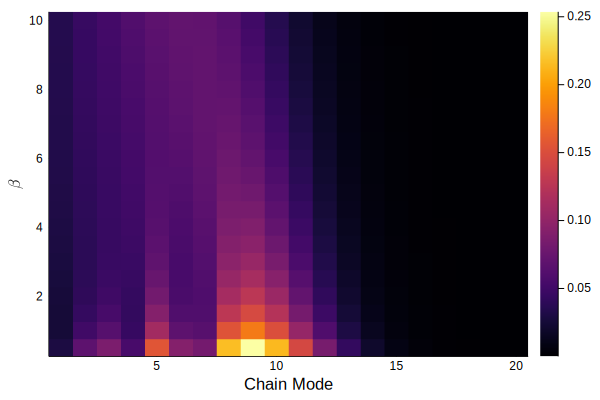

In [43]:
heatmap(mode,temperature,Z)
xlabel!("Chain Mode")
ylabel!(L"\beta")

In [44]:
Plots.savefig("Couplings_heatmap.pdf")

In [43]:
function γTbis(R::Float64, n::Int, issoft::Bool; beta=0.5, temp=[1.])
    polynomialb(t) = polybeta(t,n-1,a_chain,b_chain,[t]) #(monic(n+1,PreviousPolT,Norm2T,weight))(t)
    integrand(t) = polynomialb(t)*exp(-im*t*R*ωc/c_phonon)*SDTOhmic(t,beta)
    r = quadgk(integrand, -1, 1)[1]
    return (ωc/sqrt(Norm2T[n]))*r
end

γTbis (generic function with 1 method)

In [48]:
Nm=30;

beta = 0.5

separation = [i for i=0:0.5:40];

modes = [n for n=1:Nm];

Z = zeros(length(separation), length(modes));

documentsdir = "./TDVPMPS/"
datfname = "chaincoeffs_ohmic_a$(α)wc$(ωc)xc$(ωc/c_phonon)beta$(beta).csv"
chaincoeffs = readdlm(string(documentsdir,datfname),',',Float64,'\n',skipstart=1)
a_chain = chaincoeffs[:,1];
b_chain = chaincoeffs[:,2].^2;
# Compute the norms of the polynomials
Norm2T = []
for n=1:Nm
    polynomial(t) = polybeta(t,n-1,a_chain,b_chain,[t])
    N2(t) = polynomial(t)^2*SDTOhmic(t,beta)
    push!(Norm2T,(quadgk(N2,-1,1)[1]))
end
for i=1:length(separation)
    for n=1:length(modes)
        Z[i,n] = abs(γTbis(separation[i],modes[n],issoft,beta=beta))
    end
end


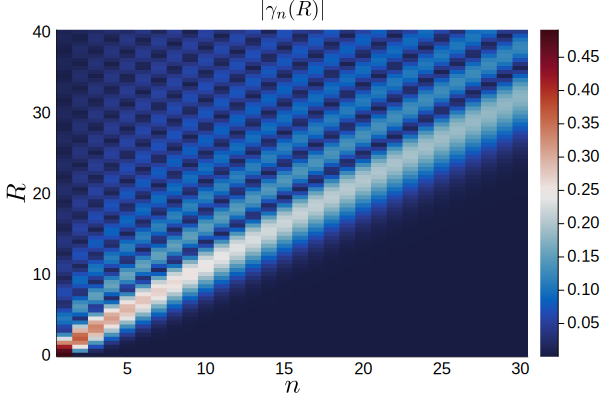

In [49]:
heatmap(modes,separation,Z, color=:balance, xguidefont=18, yguidefont=18, tickfontsize=11)
xlabel!(L"n")
ylabel!(L"R")
title!(L"|\gamma_n(R)|")

In [50]:
Plots.savefig("Abs_Couplings_heatmap_finiteT_final.pdf")

In [13]:
function couplingT(x,n)
    c = γT(x,n,issoft, beta=beta)
    return [real(c), imag(c)]
end

couplingT (generic function with 1 method)

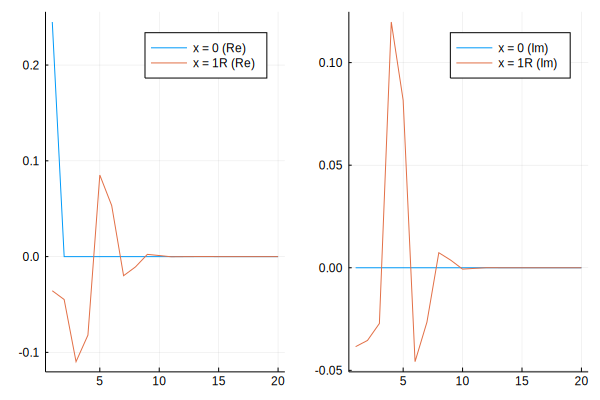

In [139]:
cRe = []
cIm = []
cAbs = []
Nm = 20
for n=1:Nm
    c = couplingT(1,n)
    push!(cRe, c[1])
    push!(cIm, c[2])
    push!(cAbs, sqrt(c[1]^2 + c[2]^2))
end
plotcouplings = Plots.plot(1:Nm, [cRe, cIm], label=["x = 0 (Re)" "x = 0 (Im)"], layout=(1,2))
for x=2:2
    cRe = []
    cIm = []
    cAbs = []
    for n=1:Nm
        c = couplingT(x,n)
        push!(cRe, c[1])
        push!(cIm, c[2])
        push!(cAbs, sqrt(c[1]^2 + c[2]^2))
    end
    plotcouplings = Plots.plot!(1:Nm, [cRe, cIm], label=["x = $(x-1)R (Re)" "x = $(x-1)R (Im)"], layout=(1,2))
end
display(plotcouplings)

In [57]:
β=beta=1e6
# Compute the norms of the polynomials
Norm2T = []
for n=1:20
    polynomial(t) = polybeta(t,n-1,a_chain,b_chain,[t])
    N2(t) = polynomial(t)^2*SDTOhmic(t)
    push!(Norm2T,quadgk(N2,-1,1)[1])
end
cRe1 = []
cIm1 = []
cRe2 = []
cIm2 = []
for n=1:20
    c1 = 2*couplingT(1,n)
    push!(cRe1, c1[1])
    push!(cIm1, c1[2])
    c2 = 2*couplingT(2,n)
    push!(cRe2, c2[1])
    push!(cIm2, c2[2])
end

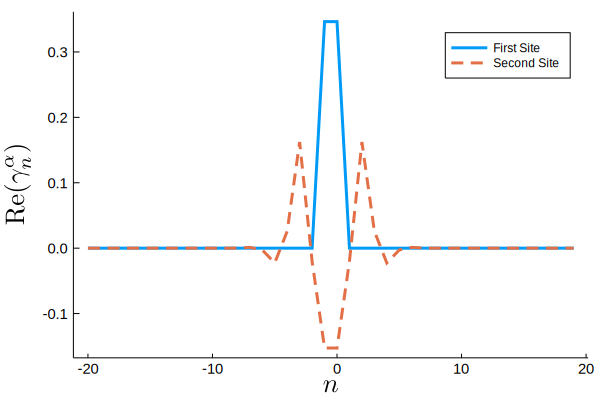

In [58]:
plotRe = Plots.plot(-20:19, [vcat(cRe1[end:-1:1],cRe1), vcat(cRe2[end:-1:1],cRe2)], linestyle=:auto, linewidth=3, label=["First Site" "Second Site"], xlabel=L"n", ylabel=L"\mathrm{Re}(\gamma_n^\alpha)", grid=:none,guidefontsize=18, tickfontsize=10, legend=:best)

In [59]:
Plots.savefig("couplings_re_T1e6.pdf")

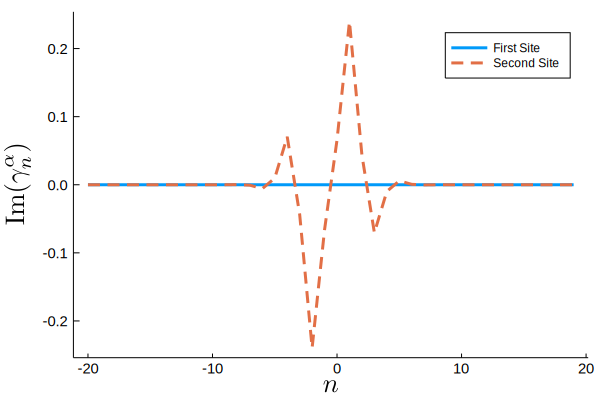

In [61]:
plotIm = Plots.plot(-20:19, [vcat(cIm1[end:-1:1],cIm1), vcat(-cIm2[end:-1:1],cIm2)], linestyle=:auto, linewidth=3, label=["First Site" "Second Site"], xlabel=L"n", ylabel=L"\mathrm{Im}(\gamma_n^\alpha)", grid=:none,guidefontsize=18, tickfontsize=10, legend=:best)

In [62]:
Plots.savefig("couplings_im_T1e6.pdf")

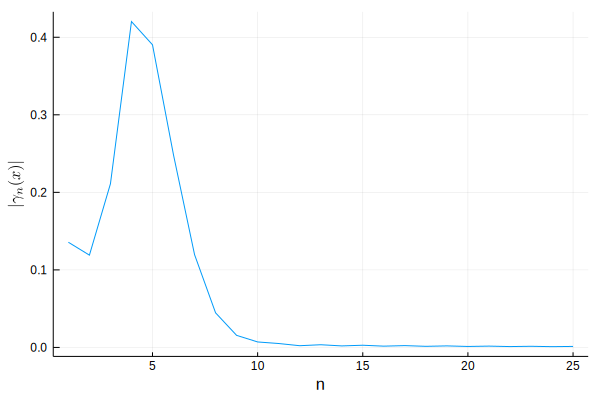

In [55]:
Plots.plot(1:Nm, cAbs, label=:none)
xlabel!("n")
ylabel!(L"|\gamma_n(x)|")

In [5]:
function monicread(n, PreviousPol, Norm2, weight, achain, bchain)
    if length(PreviousPol) >= n
        return PreviousPol[n]
    elseif length(PreviousPol) == n-1
        numerator = quadgk(t->t*PreviousPol[n-1](t)^2*weight(t),a,b)[1]
        alpha = n-2 < 1 ? 0 : achain[n-2]
        beta = n-2 <= 1 ? 0 : bchain[n-3]
        pn = t->(t - alpha)*PreviousPol[n-1](t) - beta*PreviousPol[n-2](t)
        push!(PreviousPol, pn)
        push!(Norm2, quadgk(t->pn(t)^2*weight(t), a, b)[1])
        push!(alpha_p,alpha)
        push!(beta_p,beta)
        return pn
    elseif length(PreviousPol) <= n-2
        pnminus1(t) = (monic(n-1, PreviousPol,Norm2, weight))(t)
        numerator = quadgk(t->t*pnminus1(t)^2*weight(t),a,b)[1]
        alpha = n-2 < 1 ? 0 : achain[n-2]
        beta = n-2 <= 1 ? 0 : bchain[n-3]
        pn = t->(t - alpha)*PreviousPol[n-1](t) - beta*PreviousPol[n-2](t)
        push!(PreviousPol, pn)
        push!(Norm2, quadgk(t->pn(t)^2*weight(t), a, b)[1])
        push!(alpha_p,alpha)
        push!(beta_p,beta)
        return pn
    end
end

monicread (generic function with 1 method)

In [10]:
weight(t) = SDTOhmic(t)
a = -1; b = 1;
eps_alpha = 1e-6;
PreviousPolT = [t->0, t->1];
Norm2T = [0, quadgk(SDTOhmic,a,b)[1]];
alpha_p = [];
beta_p = [];

UndefVarError: [91mUndefVarError: SDTOhmic not defined[39m

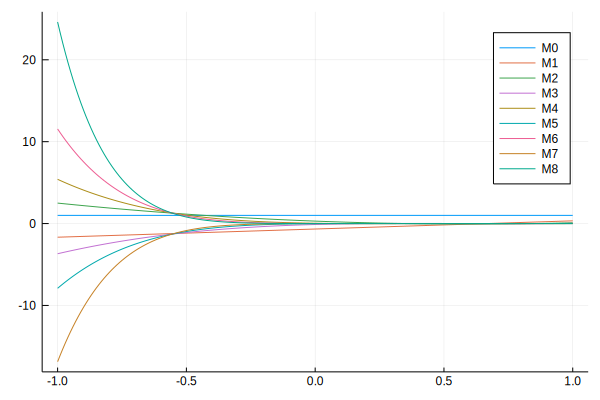

In [142]:
pltmonicread = Plots.plot(-1:0.01:1, t->(monicread(2,PreviousPolT,Norm2T, weight, a_chain, b_chain))(t), label="M0")
for n=3:10
    pltmonicread = Plots.plot!(-1:0.01:1, t->(monicread(n,PreviousPolT,Norm2T, weight, a_chain, b_chain))(t), label="M$(n-2)")
end
display(pltmonicread)

In [87]:
for n=0:5
    temp = [abs( (monicread(n+2,PreviousPolT,Norm2T,SDTOhmic,a_chain,b_chain))(t)/sqrt(Norm2T[n+2]) - polybeta(t,n,a_chain,b_chain,[t])/Norm[n+1]) for t=-1:0.01:1]
    print("n = $(n): $(max(temp...)) \n")
end

n = 0: 0.0 
n = 1: 0.0 
n = 2: 0.0 
n = 3: 0.0 
n = 4: 0.0 
n = 5: 0.0 


In [83]:
Norm

100-element Array{Any,1}:
 0.2449489742783178    
 0.057735026918962574  
 0.046337567117312774  
 0.022400318978728125  
 0.009480600950489897  
 0.005516222099195353  
 0.0027026809668713315 
 0.0012354058145325206 
 0.0006772701887071013 
 0.00033372838905593427
 0.00015699667777982593
 8.387819549727273e-5  
 4.146378263690803e-5  
 ⋮                     
 5.371294203773082e-28 
 2.7073974844791993e-28
 1.3514035994566117e-28
 6.715120088427527e-29 
 3.383861816842763e-29 
 1.6891539874779993e-29
 8.395086174291079e-30 
 4.2293827272508614e-30
 2.1113282027912227e-30
 1.0495265575465216e-30
 5.286215032740171e-31 
 2.6390305685965003e-31

In [113]:
sqrt.(Norm2T)

10-element Array{Float64,1}:
 0.0                   
 0.2449489742783178    
 0.057735026918962574  
 0.01414213562373095   
 0.003499271061118827  
 0.0008694008849288372 
 0.00021645021645021865
 5.395222026646744e-5  
 1.3458048232859576e-5 
 3.3586860589382675e-6 

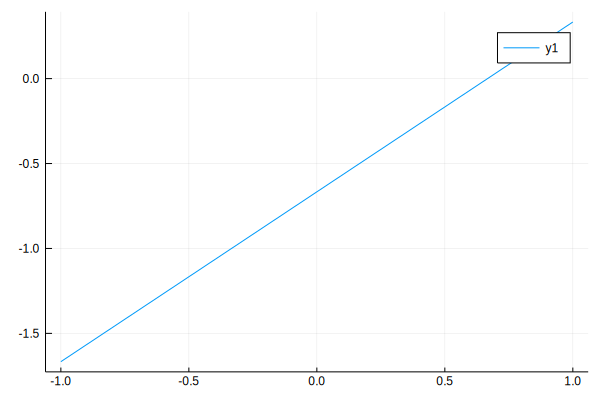

In [145]:
Plots.plot(-1:1, t->PreviousPolT[3](t))

In [149]:
quadgk(t->PreviousPolT[2](t)^2*SDTOhmic(t),-1,1)

(0.06, 0.0)

In [81]:
R = 50

50

In [68]:
f(n) = quadgk(t->(t^n*exp(im*t*R)),0,1)[1]

f (generic function with 1 method)

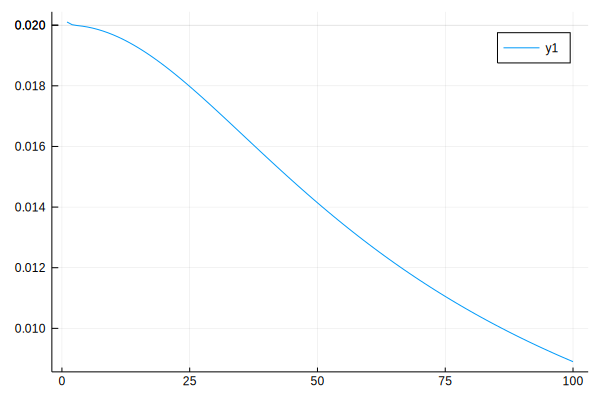

In [45]:
Plots.plot(1:100, n->abs(f(n)))

In [69]:
g(n) = quadgk(t->((t)^n*exp(im*t*R)),-1,1)[1]

g (generic function with 1 method)

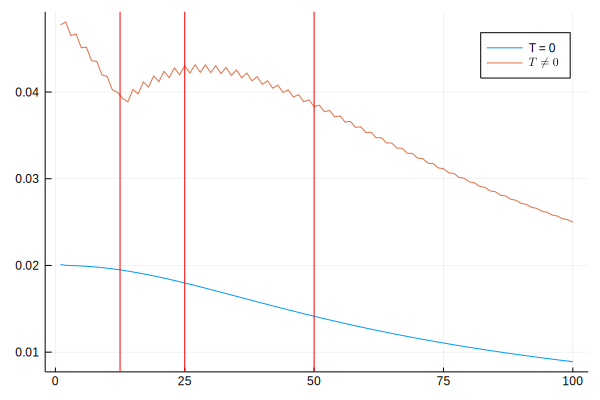

In [84]:
L = 1
Plots.plot(1:100, n->abs(f(n)), label="T = 0")
Plots.plot!(1:100, n->sum([abs(g(u)) for u=n:n+L])/L, label=L"T \neq 0")
Plots.vline!([R/4, R/2, R], linecolor=:red, label=:none)